In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [3]:
# import trip data
df = pd.read_csv('data/citibike_ZIP.csv')

In [4]:
# explore supply and demand
# find number of hourly trip starts and ends by station

starts_hrly = df.groupby(['hour','start_id'], as_index = False)[['starttime']].count()
starts_hrly.columns = ['hour','start_id','start_count']
starts_hrly

,hour,start_id,start_count
0,0,72,45
1,0,79,11
2,0,82,4
3,0,83,35
4,0,116,32
...,...,...,...
22045,23,4020,45
22046,23,4023,26
22047,23,4036,19
22048,23,4037,5


In [5]:
ends_hrly = df.groupby(['hour','end_id'], as_index = False)[['starttime']].count()
ends_hrly.columns = ['hour','end_id','end_count']
ends_hrly

,hour,end_id,end_count
0,0,72,53
1,0,79,8
2,0,82,10
3,0,83,17
4,0,116,40
...,...,...,...
22065,23,4021,1
22066,23,4023,40
22067,23,4036,11
22068,23,4037,8


In [6]:
supply_hrly = starts_hrly.merge(ends_hrly,
                               left_on = ['hour','start_id'],
                               right_on = ['hour','end_id'],
                               how = 'outer')
supply_hrly.head(10)

,hour,start_id,start_count,end_id,end_count
0,0,72.0,45.0,72.0,53.0
1,0,79.0,11.0,79.0,8.0
2,0,82.0,4.0,82.0,10.0
3,0,83.0,35.0,83.0,17.0
4,0,116.0,32.0,116.0,40.0
5,0,119.0,23.0,119.0,21.0
6,0,120.0,14.0,120.0,7.0
7,0,127.0,39.0,127.0,20.0
8,0,128.0,72.0,128.0,62.0
9,0,143.0,19.0,143.0,19.0


In [7]:
supply_hrly['end_count'].fillna(0, inplace=True)
supply_hrly['start_count'].fillna(0, inplace=True)

In [8]:
# define hourly surplus as the difference between hourly end count and start count at a station
# find daily average by dividing by 30

supply_hrly['hrly_surplus'] = (supply_hrly['end_count'] - supply_hrly['start_count'])/30
supply_hrly.head()

,hour,start_id,start_count,end_id,end_count,hrly_surplus
0,0,72.0,45.0,72.0,53.0,0.266667
1,0,79.0,11.0,79.0,8.0,-0.100000
2,0,82.0,4.0,82.0,10.0,0.200000
3,0,83.0,35.0,83.0,17.0,-0.600000
4,0,116.0,32.0,116.0,40.0,0.266667


In [9]:
pd.set_option('display.float_format', '{:.2f}'.format)
supply_hrly['hrly_surplus'].describe()

count   22558.00
mean        0.00
std         1.12
min       -25.13
25%        -0.27
50%         0.00
75%         0.27
max        36.70
Name: hrly_surplus, dtype: float64

In [16]:
# find min, max, and mean of station surplus by the hour
d = supply_hrly.groupby('hour', as_index = False)[['hrly_surplus']].agg(['mean','min','max'])
d = d['hrly_surplus'].reset_index()
d

,hour,mean,min,max
0,0,0.00,-2.97,1.20
1,1,-0.00,-1.07,0.93
2,2,0.00,-1.07,0.57
3,3,0.00,-0.53,0.50
4,4,-0.00,-0.63,1.17
5,5,-0.00,-7.80,6.47
6,6,-0.00,-11.87,36.70
7,7,0.00,-5.60,14.03
8,8,-0.00,-5.33,11.70
9,9,-0.00,-4.83,10.80


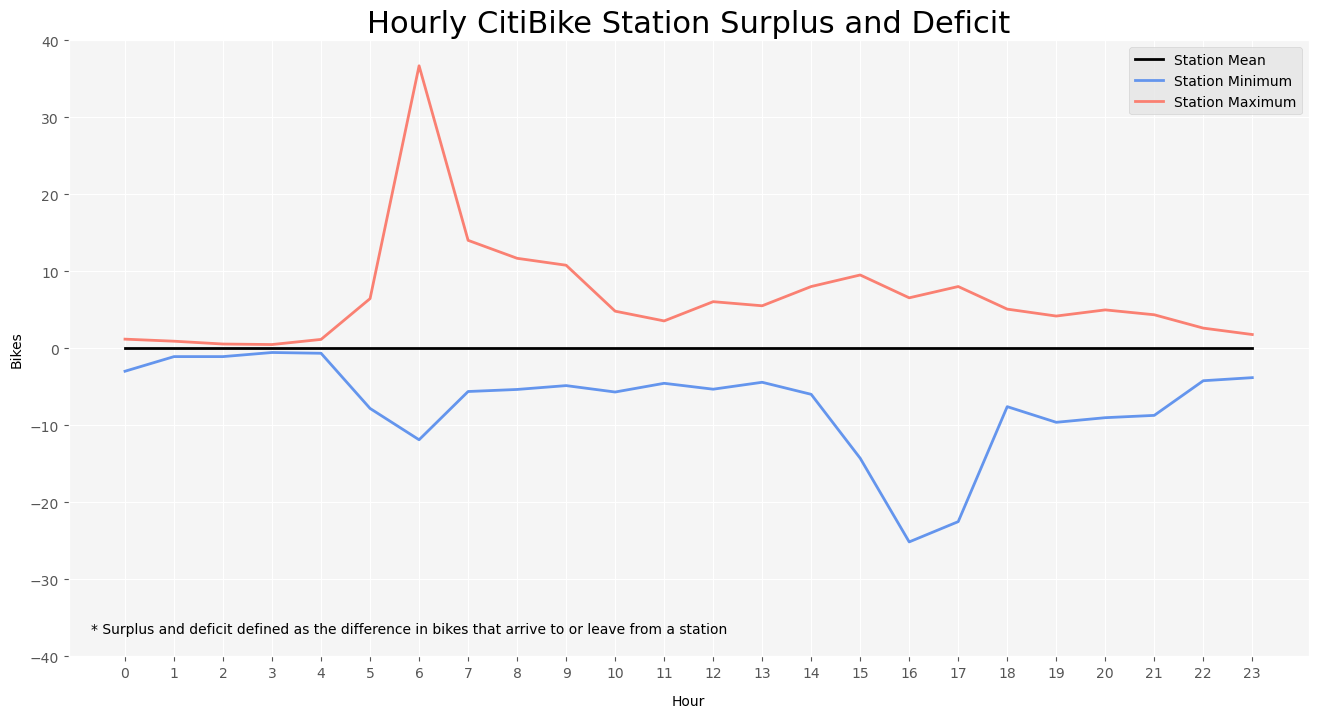

In [21]:
# line graph of hourly station surplus and deficit

fig, ax = plt.subplots(figsize=(16,8))

x = np.arange(24)
  
d.plot(ax=ax, x = 'hour', y = 'mean', color = 'black', linewidth = 2)
d.plot(ax=ax, x = 'hour', y = 'min', color = 'cornflowerblue', linewidth = 2)
d.plot(ax=ax, x = 'hour', y = 'max', color = 'salmon', linewidth = 2)

plt.xticks(x)
plt.xlabel("Hour", labelpad = 10)
plt.ylim(-40, 40)
plt.ylabel("Bikes")
plt.text(-0.7, -37, '* Surplus and deficit defined as the difference in bikes that arrive to or leave from a station')
plt.legend(['Station Mean', 'Station Minimum', 'Station Maximum'])

plt.title('Hourly CitiBike Station Surplus and Deficit', fontsize = 22)
ax.set_facecolor("whitesmoke")